In [1]:
import numpy as np
import pandas as pd
import pyarrow
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde
from scipy.spatial import ConvexHull

# Visualize Neary-normalized vowel formants

In [2]:
combined_df = pd.read_feather('./w-demog/current_12-8/S01-S48_formants_12-08-24_NORMED_cleaned.ft')
combined_df.shape

(1450063, 69)

## Define function to calculate area under the KDE curve for a given level

In [3]:
def calculate_kde_area_for_level(subset, level=0.5):
    """
    Calculate the area of a two-dimensional kernel density estimate (KDE) 
    above a specified density level.

    Args:
        subset (DataFrame or dict-like): Data containing "F2_norm" and "F1_norm".
        level (float, optional): Fraction of the maximum KDE density to consider (default: 0.5,
        widest curve if plotted levels are 0.5, 0.8, 0.9).

    Returns:
        float: Area under the KDE curve for density values above the specified level.
    """
    x, y = subset["F2_norm"], subset["F1_norm"]
    values = np.vstack([x, y])
    kernel = gaussian_kde(values)

    # Generate a fine grid
    xmin, xmax = 0.5, 2.0
    ymin, ymax = 0.2, 0.8
    X, Y = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))
    positions = np.vstack([X.ravel(), Y.ravel()])
    Z = kernel(positions).reshape(X.shape)

    # Find the density value corresponding to the specified level
    level_value = level * Z.max()

    # Calculate the area where the density exceeds the level
    area = np.sum(Z[Z > level_value])
    dx = (xmax - xmin) / 100
    dy = (ymax - ymin) / 100
    return area * dx * dy

## All measurements per token

### Add by-token timepoint indices
Useful for modeling later to include tpt predictor

In [4]:
combined_df['tpt'] = combined_df.groupby(['t1', 'recording']).cumcount()
combined_df[(combined_df['t1'] == 10.579) & (combined_df['recording'] == 'S01_interview.wav')]

,phones_short,F1_norm,F2_norm,F3_norm,t1,t2,recording,phones,phone_dur,words,...,sexuality_gender_cut,sexuality_race_cut,race_ethn_cut,sexuality_socioecon_cut,socio_econ_cut,sexuality_place_cut,place_origin_cut,sexuality_L1s_cut,L1s_cut,tpt
0,EY,0.406,1.784,2.455,10.579,10.779,S01_interview.wav,EY1,0.2,day,...,bi+ non-binary,bi+ white,white,bi+ upper-middle+,upper-middle+,bi+ East US,East US,bi+ English mono,English mono,0
1,EY,0.429,1.697,2.441,10.579,10.779,S01_interview.wav,EY1,0.2,day,...,bi+ non-binary,bi+ white,white,bi+ upper-middle+,upper-middle+,bi+ East US,East US,bi+ English mono,English mono,1
2,EY,0.425,1.710,2.367,10.579,10.779,S01_interview.wav,EY1,0.2,day,...,bi+ non-binary,bi+ white,white,bi+ upper-middle+,upper-middle+,bi+ East US,East US,bi+ English mono,English mono,2
3,EY,0.424,1.719,2.272,10.579,10.779,S01_interview.wav,EY1,0.2,day,...,bi+ non-binary,bi+ white,white,bi+ upper-middle+,upper-middle+,bi+ East US,East US,bi+ English mono,English mono,3
4,EY,0.411,1.745,2.261,10.579,10.779,S01_interview.wav,EY1,0.2,day,...,bi+ non-binary,bi+ white,white,bi+ upper-middle+,upper-middle+,bi+ East US,East US,bi+ English mono,English mono,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,EY,0.418,1.653,2.365,10.579,10.779,S01_interview.wav,EY1,0.2,day,...,bi+ non-binary,bi+ white,white,bi+ upper-middle+,upper-middle+,bi+ East US,East US,bi+ English mono,English mono,199
200,EY,0.403,1.646,2.080,10.579,10.779,S01_interview.wav,EY1,0.2,day,...,bi+ non-binary,bi+ white,white,bi+ upper-middle+,upper-middle+,bi+ East US,East US,bi+ English mono,English mono,200
201,EY,0.392,1.704,1.962,10.579,10.779,S01_interview.wav,EY1,0.2,day,...,bi+ non-binary,bi+ white,white,bi+ upper-middle+,upper-middle+,bi+ East US,East US,bi+ English mono,English mono,201
202,EY,0.391,1.686,2.061,10.579,10.779,S01_interview.wav,EY1,0.2,day,...,bi+ non-binary,bi+ white,white,bi+ upper-middle+,upper-middle+,bi+ East US,East US,bi+ English mono,English mono,202


In [5]:
#combined_df.to_feather('./w-demog/current_12-8/S01-S48_formants_12-30-24_tpts.ft')

### Get sexuality_gender subsets

In [6]:
subset_hm = combined_df[combined_df['sexuality_gender_cut'] == 'heterosexual masculine']

subset_gm = combined_df[combined_df['sexuality_gender_cut'] == 'gay masculine']

subset_hf = combined_df[combined_df['sexuality_gender_cut'] == 'heterosexual feminine']

subset_bf = combined_df[combined_df['sexuality_gender_cut'] == 'bi+ feminine']

subset_snb = combined_df[combined_df['sexuality_gender_cut'] == 'sapphic non-binary']

subset_bnb = combined_df[combined_df['sexuality_gender_cut'] == 'bi+ non-binary']
subset_hm.columns.values.tolist()

['phones_short',
 'F1_norm',
 'F2_norm',
 'F3_norm',
 't1',
 't2',
 'recording',
 'phones',
 'phone_dur',
 'words',
 'time(s)',
 'intensity',
 'nformants',
 'F1(Hz)',
 'B1(Hz)',
 'F2(Hz)',
 'B2(Hz)',
 'F3(Hz)',
 'B3(Hz)',
 'F4(Hz)',
 'B4(Hz)',
 'F5(Hz)',
 'B5(Hz)',
 'Ceiling(Hz)',
 'Stress',
 'task',
 'nxt',
 'nxt_height',
 'nxt_back',
 'prev',
 'prev_height',
 'prev_back',
 'spk_num',
 'age',
 'gender',
 'gender_crude',
 'gender_normative',
 'masc',
 'femme',
 'sexual_orientation',
 'sexuality_mid',
 'sexuality_crude',
 'sexuality_normative',
 'sexuality_gender',
 'race_ethn1',
 'race_ethn2',
 'socio_econ',
 'place_origin',
 'L1s',
 'other_langs',
 'sexuality_race',
 'race_ethn_stats',
 'sexuality_socioecon',
 'sexuality_place',
 'sexuality_L1s',
 'race_ethn_crude',
 'socio_econ_crude',
 'place_origin_crude',
 'L1s_crude',
 'speaker',
 'sexuality_gender_cut',
 'sexuality_race_cut',
 'race_ethn_cut',
 'sexuality_socioecon_cut',
 'socio_econ_cut',
 'sexuality_place_cut',
 'place_origin_

### Plot by-phone, by-sexuality/gender means, get area of 90th density percentile
This may take several minutes..

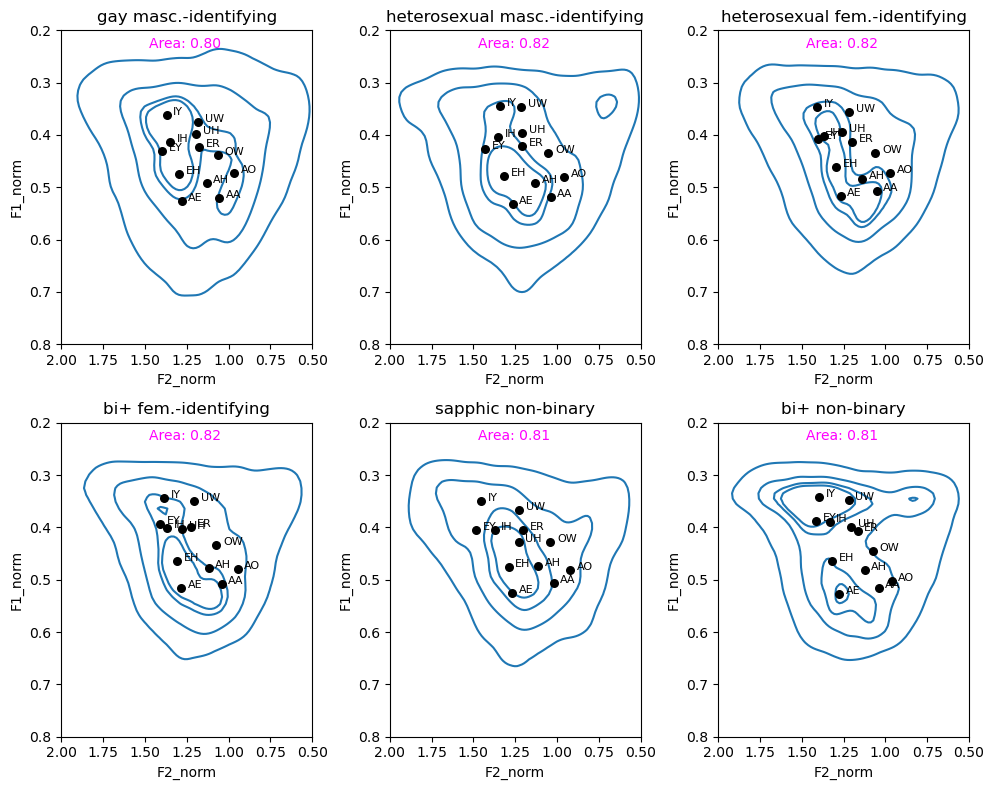

In [7]:
mean_points = combined_df.groupby(['phones_short', 'sexuality_gender_cut']).agg({'F1_norm': 'mean', 'F2_norm': 'mean'}).reset_index()

subsets = [subset_gm, subset_hm, subset_hf, subset_bf, subset_snb, subset_bnb]
titles = [
    'gay masc.-identifying',
    'heterosexual masc.-identifying',
    'heterosexual fem.-identifying',
    'bi+ fem.-identifying',
    'sapphic non-binary',
    'bi+ non-binary'
]

# Clean data to remove NaNs or infinities
cleaned_subsets = []
for subset in subsets:
    cleaned_subset = subset[np.isfinite(subset['F1_norm']) & np.isfinite(subset['F2_norm'])].dropna(subset=['F1_norm', 'F2_norm'])
    cleaned_subsets.append(cleaned_subset)

# Calculate areas under the KDE curve for each subset
areas = {}
for subset, title in zip(cleaned_subsets, titles):
    areas[title] = calculate_kde_area_for_level(subset, level=0.2)

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

# Plot KDEs, overlay means, and add areas to the plots
for ax, subset, title in zip(axes.flat, cleaned_subsets, titles):
    # KDE plot
    sns.kdeplot(
        data=subset, x="F2_norm", y="F1_norm", hue="sexuality_gender_cut",
        levels=[0.2, 0.5, 0.8, 0.9], cut=0, common_norm=False, legend=False, ax=ax
    )
    
    # Plot means (smaller points) based on by-token means
    subset_means = mean_points[mean_points['sexuality_gender_cut'].isin(subset['sexuality_gender_cut'].unique())]
    ax.scatter(subset_means['F2_norm'], subset_means['F1_norm'], color='black', zorder=3, s=30)
    
    # Add labels for means
    for _, row in subset_means.iterrows():
        ax.text(
            row['F2_norm'] - 0.04, row['F1_norm'],
            row['phones_short'], fontsize=8, color='black', zorder=4
        )
    
    # Display the calculated area in the top-left corner
    area = areas[title]
    ax.text(0.35, 0.98, f"Area: {area:.2f}", fontsize=10, color='magenta', transform=ax.transAxes, ha='left', va='top')
    
    # Set titles and limits
    ax.set_title(title)
    ax.set_xlim(0.5, 2.0)
    ax.set_ylim(0.2, 0.8)
    ax.set_xlabel('F2_norm')
    ax.set_ylabel('F1_norm')
    ax.invert_xaxis()
    ax.invert_yaxis()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Print areas for reference
#for group, area in areas.items():
#    print(f"Area under the 0.9 density for {group}: {area}")

## By-token means

### Get by-token means

In [8]:
grouped_means = combined_df.groupby(['t1', 'recording'], as_index=False).agg(
    {col: 'mean' if col in ['F1(Hz)', 'F2(Hz)', 'F1_norm', 'F2_norm'] else 'first' for col in combined_df.columns}
)
grouped_means

,phones_short,F1_norm,F2_norm,F3_norm,t1,t2,recording,phones,phone_dur,words,...,sexuality_gender_cut,sexuality_race_cut,race_ethn_cut,sexuality_socioecon_cut,socio_econ_cut,sexuality_place_cut,place_origin_cut,sexuality_L1s_cut,L1s_cut,tpt
0,IH,0.412806,1.534935,1.829,0.33,0.43,S45_S46_map_task_2.wav,OW1,0.10,don't,...,heterosexual feminine,heterosexual other,Black/mixed,heterosexual upper-middle+,working/lower,heterosexual other US,South US,heterosexual English(+),English mono,0
1,AE,0.271000,1.457258,1.801,0.53,0.63,S45_S46_map_task_2.wav,IY1,0.10,need,...,heterosexual feminine,heterosexual other,Black/mixed,heterosexual upper-middle+,working/lower,heterosexual other US,South US,heterosexual English(+),English mono,0
2,AE,0.504440,1.095720,2.033,0.72,0.79,S03_interview_2.wav,EY1,0.07,frustrations,...,bi+ feminine,bi+ Black/mixed,Black/mixed,bi+ working/lower,working/lower,bi+ West US,West US,bi+ English bilingual,English bilingual,0
3,AE,0.418400,1.600320,1.782,0.94,1.01,S45_S46_map_task_2.wav,IY1,0.07,see,...,heterosexual feminine,heterosexual other,Black/mixed,heterosexual upper-middle+,working/lower,heterosexual other US,South US,heterosexual English(+),English mono,0
4,AH,0.487478,0.972870,1.626,1.14,1.20,S03_interview_2.wav,IY1,0.06,be,...,bi+ feminine,bi+ Black/mixed,Black/mixed,bi+ working/lower,working/lower,bi+ West US,West US,bi+ English bilingual,English bilingual,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38477,OW,0.531370,1.184296,1.878,2114.17,2114.25,S45_interview.wav,EY1,0.08,gay,...,gay masculine,gay other,white,gay middle,upper-middle+,gay US,South US,gay English(+),English mono,0
38478,OW,0.330840,1.046640,1.505,2114.62,2114.69,S45_interview.wav,IY1,0.07,see,...,gay masculine,gay other,white,gay middle,upper-middle+,gay US,South US,gay English(+),English mono,0
38479,OW,0.479696,1.185174,1.743,2116.20,2116.26,S45_interview.wav,AO1,0.06,normal,...,gay masculine,gay other,white,gay middle,upper-middle+,gay US,South US,gay English(+),English mono,0
38480,AO,0.538217,1.663652,2.712,2152.58,2152.64,S45_interview.wav,IH1,0.06,think,...,gay masculine,gay other,white,gay middle,upper-middle+,gay US,South US,gay English(+),English mono,0


### Get new sexuality_gender subsets

In [9]:
subset_hm1 = grouped_means[grouped_means['sexuality_gender_cut'] == 'heterosexual masculine']

subset_gm1 = grouped_means[grouped_means['sexuality_gender_cut'] == 'gay masculine']

subset_hf1 = grouped_means[grouped_means['sexuality_gender_cut'] == 'heterosexual feminine']

subset_bf1 = grouped_means[grouped_means['sexuality_gender_cut'] == 'bi+ feminine']

subset_snb1 = grouped_means[grouped_means['sexuality_gender_cut'] == 'sapphic non-binary']

subset_bnb1 = grouped_means[grouped_means['sexuality_gender_cut'] == 'bi+ non-binary']
subset_hm1.columns.values.tolist()

['phones_short',
 'F1_norm',
 'F2_norm',
 'F3_norm',
 't1',
 't2',
 'recording',
 'phones',
 'phone_dur',
 'words',
 'time(s)',
 'intensity',
 'nformants',
 'F1(Hz)',
 'B1(Hz)',
 'F2(Hz)',
 'B2(Hz)',
 'F3(Hz)',
 'B3(Hz)',
 'F4(Hz)',
 'B4(Hz)',
 'F5(Hz)',
 'B5(Hz)',
 'Ceiling(Hz)',
 'Stress',
 'task',
 'nxt',
 'nxt_height',
 'nxt_back',
 'prev',
 'prev_height',
 'prev_back',
 'spk_num',
 'age',
 'gender',
 'gender_crude',
 'gender_normative',
 'masc',
 'femme',
 'sexual_orientation',
 'sexuality_mid',
 'sexuality_crude',
 'sexuality_normative',
 'sexuality_gender',
 'race_ethn1',
 'race_ethn2',
 'socio_econ',
 'place_origin',
 'L1s',
 'other_langs',
 'sexuality_race',
 'race_ethn_stats',
 'sexuality_socioecon',
 'sexuality_place',
 'sexuality_L1s',
 'race_ethn_crude',
 'socio_econ_crude',
 'place_origin_crude',
 'L1s_crude',
 'speaker',
 'sexuality_gender_cut',
 'sexuality_race_cut',
 'race_ethn_cut',
 'sexuality_socioecon_cut',
 'socio_econ_cut',
 'sexuality_place_cut',
 'place_origin_

### Plot by-phone, by-sexuality/gender means w/ area of 80% distribution

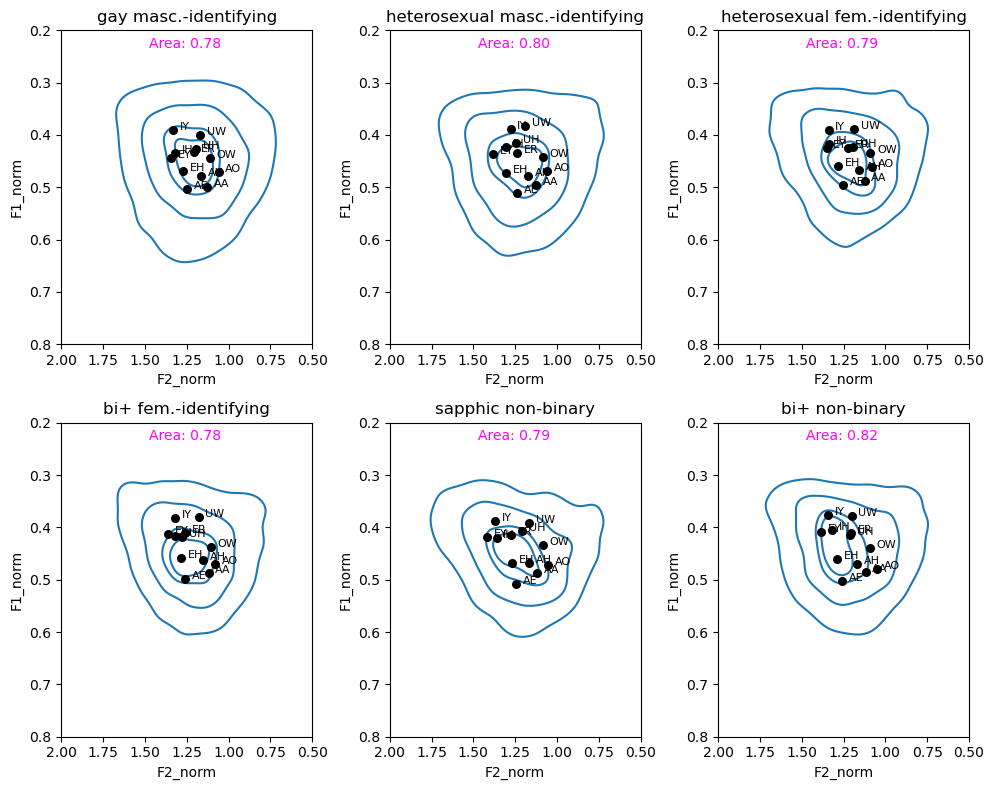

In [10]:
# Calculate means
mean_points1 = grouped_means.groupby(['phones_short', 'sexuality_gender_cut']).agg({'F1_norm': 'mean', 'F2_norm': 'mean'}).reset_index()

# Define subsets and titles
subsets = [subset_gm1, subset_hm1, subset_hf1, subset_bf1, subset_snb1, subset_bnb1]
titles = [
    'gay masc.-identifying',
    'heterosexual masc.-identifying',
    'heterosexual fem.-identifying',
    'bi+ fem.-identifying',
    'sapphic non-binary',
    'bi+ non-binary'
]

# Clean data to remove NaNs or infinities
cleaned_subsets = []
for subset in subsets:
    cleaned_subset = subset[np.isfinite(subset['F1_norm']) & np.isfinite(subset['F2_norm'])].dropna(subset=['F1_norm', 'F2_norm'])
    cleaned_subsets.append(cleaned_subset)

# Calculate areas under the KDE curve for each subset
areas = {}
for subset, title in zip(cleaned_subsets, titles):
    areas[title] = calculate_kde_area_for_level(subset, level=0.2)

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

# Plot KDEs, overlay means, and add areas to the plots
for ax, subset, title in zip(axes.flat, cleaned_subsets, titles):
    # KDE plot
    sns.kdeplot(
        data=subset, x="F2_norm", y="F1_norm", hue="sexuality_gender_cut",
        levels=[0.2, 0.5, 0.8, 0.9], cut=0, common_norm=False, legend=False, ax=ax
    )
    
    # Plot means (smaller points) based on by-token means
    subset_means = mean_points1[mean_points1['sexuality_gender_cut'].isin(subset['sexuality_gender_cut'].unique())]
    ax.scatter(subset_means['F2_norm'], subset_means['F1_norm'], color='black', zorder=3, s=30)
    
    # Add labels for means
    for _, row in subset_means.iterrows():
        ax.text(
            row['F2_norm'] - 0.04, row['F1_norm'],
            row['phones_short'], fontsize=8, color='black', zorder=4
        )
    
    # Display the calculated area in the top-left corner
    area = areas[title]
    ax.text(0.35, 0.98, f"Area: {area:.2f}", fontsize=10, color='magenta', transform=ax.transAxes, ha='left', va='top')
    
    # Set titles and limits
    ax.set_title(title)
    ax.set_xlim(0.5, 2.0)
    ax.set_ylim(0.2, 0.8)
    ax.set_xlabel('F2_norm')
    ax.set_ylabel('F1_norm')
    ax.invert_xaxis()
    ax.invert_yaxis()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Print areas for reference
#for group, area in areas.items():
#    print(f"Area under the 0.9 density for {group}: {area}")

## By-token medians

### Get by-token medians

In [11]:
grouped_meds = combined_df.groupby(['t1', 'recording'], as_index=False).agg(
    {col: 'median' if col in ['F1(Hz)', 'F2(Hz)', 'F1_norm', 'F2_norm'] else 'first' for col in combined_df.columns}
)
grouped_meds

,phones_short,F1_norm,F2_norm,F3_norm,t1,t2,recording,phones,phone_dur,words,...,sexuality_gender_cut,sexuality_race_cut,race_ethn_cut,sexuality_socioecon_cut,socio_econ_cut,sexuality_place_cut,place_origin_cut,sexuality_L1s_cut,L1s_cut,tpt
0,IH,0.4270,1.584,1.829,0.33,0.43,S45_S46_map_task_2.wav,OW1,0.10,don't,...,heterosexual feminine,heterosexual other,Black/mixed,heterosexual upper-middle+,working/lower,heterosexual other US,South US,heterosexual English(+),English mono,0
1,AE,0.2500,1.444,1.801,0.53,0.63,S45_S46_map_task_2.wav,IY1,0.10,need,...,heterosexual feminine,heterosexual other,Black/mixed,heterosexual upper-middle+,working/lower,heterosexual other US,South US,heterosexual English(+),English mono,0
2,AE,0.5150,1.116,2.033,0.72,0.79,S03_interview_2.wav,EY1,0.07,frustrations,...,bi+ feminine,bi+ Black/mixed,Black/mixed,bi+ working/lower,working/lower,bi+ West US,West US,bi+ English bilingual,English bilingual,0
3,AE,0.4100,1.625,1.782,0.94,1.01,S45_S46_map_task_2.wav,IY1,0.07,see,...,heterosexual feminine,heterosexual other,Black/mixed,heterosexual upper-middle+,working/lower,heterosexual other US,South US,heterosexual English(+),English mono,0
4,AH,0.5200,1.018,1.626,1.14,1.20,S03_interview_2.wav,IY1,0.06,be,...,bi+ feminine,bi+ Black/mixed,Black/mixed,bi+ working/lower,working/lower,bi+ West US,West US,bi+ English bilingual,English bilingual,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38477,OW,0.5470,1.150,1.878,2114.17,2114.25,S45_interview.wav,EY1,0.08,gay,...,gay masculine,gay other,white,gay middle,upper-middle+,gay US,South US,gay English(+),English mono,0
38478,OW,0.2820,1.097,1.505,2114.62,2114.69,S45_interview.wav,IY1,0.07,see,...,gay masculine,gay other,white,gay middle,upper-middle+,gay US,South US,gay English(+),English mono,0
38479,OW,0.6280,1.231,1.743,2116.20,2116.26,S45_interview.wav,AO1,0.06,normal,...,gay masculine,gay other,white,gay middle,upper-middle+,gay US,South US,gay English(+),English mono,0
38480,AO,0.4390,1.668,2.712,2152.58,2152.64,S45_interview.wav,IH1,0.06,think,...,gay masculine,gay other,white,gay middle,upper-middle+,gay US,South US,gay English(+),English mono,0


### Get new sexuality-gender groups

In [12]:
subset_hm2 = grouped_meds[grouped_meds['sexuality_gender_cut'] == 'heterosexual masculine']

subset_gm2 = grouped_meds[grouped_meds['sexuality_gender_cut'] == 'gay masculine']

subset_hf2 = grouped_meds[grouped_meds['sexuality_gender_cut'] == 'heterosexual feminine']

subset_bf2 = grouped_meds[grouped_meds['sexuality_gender_cut'] == 'bi+ feminine']

subset_snb2 = grouped_meds[grouped_meds['sexuality_gender_cut'] == 'sapphic non-binary']

subset_bnb2 = grouped_meds[grouped_meds['sexuality_gender_cut'] == 'bi+ non-binary']
subset_hm2.columns.values.tolist()

['phones_short',
 'F1_norm',
 'F2_norm',
 'F3_norm',
 't1',
 't2',
 'recording',
 'phones',
 'phone_dur',
 'words',
 'time(s)',
 'intensity',
 'nformants',
 'F1(Hz)',
 'B1(Hz)',
 'F2(Hz)',
 'B2(Hz)',
 'F3(Hz)',
 'B3(Hz)',
 'F4(Hz)',
 'B4(Hz)',
 'F5(Hz)',
 'B5(Hz)',
 'Ceiling(Hz)',
 'Stress',
 'task',
 'nxt',
 'nxt_height',
 'nxt_back',
 'prev',
 'prev_height',
 'prev_back',
 'spk_num',
 'age',
 'gender',
 'gender_crude',
 'gender_normative',
 'masc',
 'femme',
 'sexual_orientation',
 'sexuality_mid',
 'sexuality_crude',
 'sexuality_normative',
 'sexuality_gender',
 'race_ethn1',
 'race_ethn2',
 'socio_econ',
 'place_origin',
 'L1s',
 'other_langs',
 'sexuality_race',
 'race_ethn_stats',
 'sexuality_socioecon',
 'sexuality_place',
 'sexuality_L1s',
 'race_ethn_crude',
 'socio_econ_crude',
 'place_origin_crude',
 'L1s_crude',
 'speaker',
 'sexuality_gender_cut',
 'sexuality_race_cut',
 'race_ethn_cut',
 'sexuality_socioecon_cut',
 'socio_econ_cut',
 'sexuality_place_cut',
 'place_origin_

### Plot by-phone, by-sexuality/gender means w/ area of 80% distribution

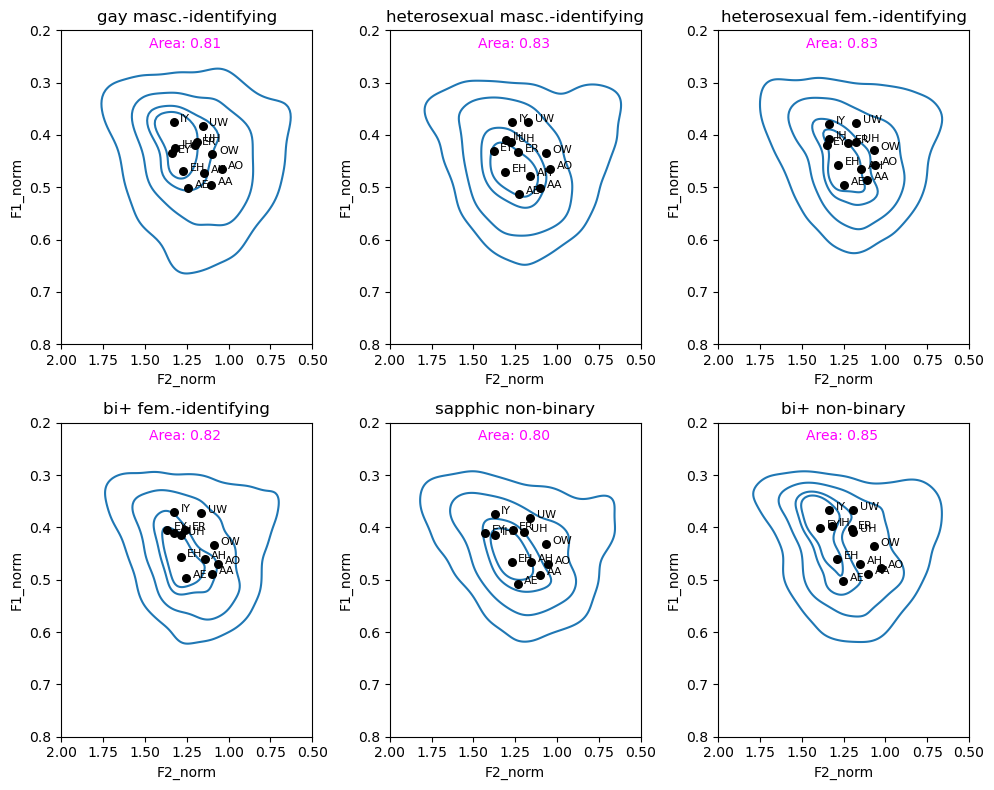

In [13]:
# Calculate means
mean_points2 = grouped_meds.groupby(['phones_short', 'sexuality_gender_cut']).agg({'F1_norm': 'mean', 'F2_norm': 'mean'}).reset_index()

# Define subsets and titles
subsets = [subset_gm2, subset_hm2, subset_hf2, subset_bf2, subset_snb2, subset_bnb2]
titles = [
    'gay masc.-identifying',
    'heterosexual masc.-identifying',
    'heterosexual fem.-identifying',
    'bi+ fem.-identifying',
    'sapphic non-binary',
    'bi+ non-binary'
]

cleaned_subsets = []
for subset in subsets:
    cleaned_subset = subset[np.isfinite(subset['F1_norm']) & np.isfinite(subset['F2_norm'])].dropna(subset=['F1_norm', 'F2_norm'])
    cleaned_subsets.append(cleaned_subset)

areas = {}
for subset, title in zip(cleaned_subsets, titles):
    areas[title] = calculate_kde_area_for_level(subset, level=0.2)
    
# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

# Plot KDEs and overlay means
for ax, subset, title in zip(axes.flat, subsets, titles):
    # KDE plot
    sns.kdeplot(
        data=subset, x="F2_norm", y="F1_norm", hue="sexuality_gender_cut",
        levels=[0.2, 0.5, 0.8, 0.9], cut=0, common_norm=False, legend=False, ax=ax
    )
    
    # Plot means (smaller points)
    subset_means = mean_points2[mean_points2['sexuality_gender_cut'].isin(subset['sexuality_gender_cut'].unique())]
    ax.scatter(subset_means['F2_norm'], subset_means['F1_norm'], color='black', zorder=3, s=30)  # Adjust size with s=30
    
    # Add labels (with offset)
    for _, row in subset_means.iterrows():
        ax.text(
            row['F2_norm'] - 0.04, row['F1_norm'],  # Offset text position for better spacing
            row['phones_short'], fontsize=8, color='black', zorder=4
        )
    
    # Annotate area at the top of the panel
    area = areas[title]
    ax.text(0.35, 0.945, f"Area: {area:.2f}", fontsize=10, color='magenta', transform=ax.transAxes)
    
    # Set titles and limits
    ax.set_title(title)
    ax.set_xlim(0.5, 2.0)
    ax.set_ylim(0.2, 0.8)
    ax.set_xlabel('F2_norm')
    ax.set_ylabel('F1_norm')
    ax.invert_xaxis()  # Invert x-axis
    ax.invert_yaxis()  # Invert y-axis

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Print areas for reference
#for group, area in areas.items():
#    print(f"Area under the 0.9 density for {group}: {area}")

### Plot raw group means w/ confidence intervals
Roughly matches the output of plotting emmeans results in R

In [14]:
grouped_meds.dropna(subset=["F1_norm", "F2_norm"], inplace=True)

In [15]:
grouped_meds.groupby('sexuality_gender_cut')[['F1_norm', 'F2_norm']].mean().reset_index().sort_values(by='F1_norm', ascending=True)

,sexuality_gender_cut,F1_norm,F2_norm
2,exclude,0.434673,1.204921
1,bi+ non-binary,0.441252,1.223566
4,heterosexual feminine,0.442487,1.214847
0,bi+ feminine,0.443150,1.217788
6,sapphic non-binary,0.447909,1.230613
3,gay masculine,0.451461,1.209569
5,heterosexual masculine,0.454095,1.210999


In [16]:
from scipy.stats import sem, t

def mean_confidence_interval(data, confidence=0.95):
    n = len(data)
    if n < 2:  # Cannot calculate CI with fewer than 2 data points
        mean = np.mean(data)
        return mean, np.nan, np.nan
    mean = np.mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)  # Margin of error
    return mean, mean - h, mean + h

# Group by `sexuality_gender_cut` and calculate stats
results = []
for name, group in grouped_meds.groupby('sexuality_gender_cut'):
    f1_mean, f1_lower, f1_upper = mean_confidence_interval(group['F1_norm'])
    f2_mean, f2_lower, f2_upper = mean_confidence_interval(group['F2_norm'])
    results.append({
        'sexuality_gender_cut': name,
        'F1_norm_mean': f1_mean,
        'F1_norm_lower': f1_lower,
        'F1_norm_upper': f1_upper,
        'F2_norm_mean': f2_mean,
        'F2_norm_lower': f2_lower,
        'F2_norm_upper': f2_upper
    })

ci_df = pd.DataFrame(results)
ci_df

,sexuality_gender_cut,F1_norm_mean,F1_norm_lower,F1_norm_upper,F2_norm_mean,F2_norm_lower,F2_norm_upper
0,bi+ feminine,0.443150,0.441347,0.444953,1.217788,1.212497,1.223080
1,bi+ non-binary,0.441252,0.438932,0.443573,1.223566,1.216472,1.230660
2,exclude,0.434673,0.430943,0.438403,1.204921,1.193610,1.216231
3,gay masculine,0.451461,0.448449,0.454472,1.209569,1.201940,1.217198
4,heterosexual feminine,0.442487,0.440354,0.444620,1.214847,1.208685,1.221009
5,heterosexual masculine,0.454095,0.450600,0.457590,1.210999,1.200860,1.221138
6,sapphic non-binary,0.447909,0.444777,0.451041,1.230613,1.220392,1.240833


In [17]:
ci_df = ci_df[ci_df['sexuality_gender_cut'] != 'exclude']

Replace 'F2' with 'F1' below as needed:

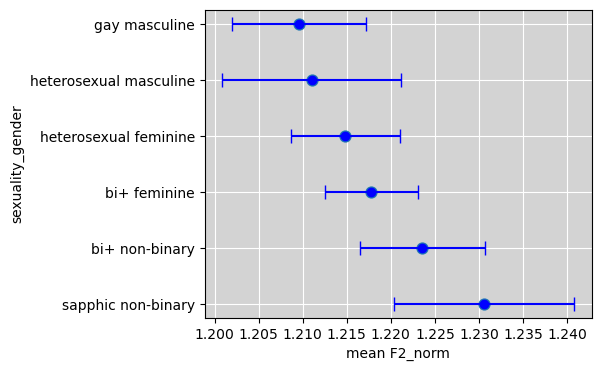

In [18]:
# Manually set the order of 'sexuality_gender_cut' for the y-axis
#order = ['bi+ non-binary', 'heterosexual feminine', 'bi+ feminine', 'sapphic non-binary',
#        'gay masculine', 'heterosexual masculine']
order = ['gay masculine', 'heterosexual masculine', 'heterosexual feminine', 
         'bi+ feminine', 'bi+ non-binary', 'sapphic non-binary']

plt.figure(figsize=(5, 4))
sns.pointplot(
    data=ci_df,
    x='F2_norm_mean',
    y='sexuality_gender_cut',
    order=order,  # Set the order of categories on the y-axis
    linestyle='none',  # No line connecting the points
    errorbar=None  # Turn off automatic confidence intervals from seaborn
)

# Add custom confidence intervals
for i, row in ci_df.iterrows():
    plt.errorbar(
        y=row['sexuality_gender_cut'],
        x=row['F2_norm_mean'],
        xerr=[[row['F2_norm_mean'] - row['F2_norm_lower']], [row['F2_norm_upper'] - row['F2_norm_mean']]],
        fmt='o',  # Marker style
        color='blue',  # Error bar color
        capsize=5  # Error bar cap size
    )

# Set labels and title
plt.xlabel('mean F2_norm')
plt.ylabel('sexuality_gender')
#plt.title('Mean F1_norm with Confidence Intervals')

# Set the background color to gray
plt.gca().set_facecolor('lightgray')  # Gray background for the plot area

# Add white horizontal grid lines
plt.grid(True, axis='y', linestyle='-', color='white')  # Horizontal grid lines in white
plt.grid(True, axis='x', linestyle='-', color='white') 

# Show the plot
plt.show()

# Visualize overlapping full vowel spaces by social group

In [19]:
# use feather format to save memory
medians_df = pd.read_feather('./w-demog/current_12-8/S01-S48_formants_12-08-24_NORMED_medians.ft')
medians_df.head()

,phones_short,F1_norm,F2_norm,F3_norm,t1,t2,recording,phones,phone_dur,words,...,speaker,sexuality_gender_cut,sexuality_race_cut,race_ethn_cut,sexuality_socioecon_cut,socio_econ_cut,sexuality_place_cut,place_origin_cut,sexuality_L1s_cut,L1s_cut
0,IH,0.427,1.584,1.829,0.33,0.43,S45_S46_map_task_2.wav,OW1,0.10,don't,...,S46,heterosexual feminine,heterosexual other,Black/mixed,heterosexual upper-middle+,working/lower,heterosexual other US,South US,heterosexual English(+),English mono
1,AE,0.250,1.444,1.801,0.53,0.63,S45_S46_map_task_2.wav,IY1,0.10,need,...,S46,heterosexual feminine,heterosexual other,Black/mixed,heterosexual upper-middle+,working/lower,heterosexual other US,South US,heterosexual English(+),English mono
2,AE,0.515,1.116,2.033,0.72,0.79,S03_interview_2.wav,EY1,0.07,frustrations,...,S03,bi+ feminine,bi+ Black/mixed,Black/mixed,bi+ working/lower,working/lower,bi+ West US,West US,bi+ English bilingual,English bilingual
3,AE,0.410,1.625,1.782,0.94,1.01,S45_S46_map_task_2.wav,IY1,0.07,see,...,S46,heterosexual feminine,heterosexual other,Black/mixed,heterosexual upper-middle+,working/lower,heterosexual other US,South US,heterosexual English(+),English mono
4,AH,0.520,1.018,1.626,1.14,1.20,S03_interview_2.wav,IY1,0.06,be,...,S03,bi+ feminine,bi+ Black/mixed,Black/mixed,bi+ working/lower,working/lower,bi+ West US,West US,bi+ English bilingual,English bilingual


In [20]:
medians_df = medians_df[medians_df['sexuality_gender_cut'] != 'exclude']
medians_df['sexuality_gender_cut'].unique()

array(['heterosexual feminine', 'bi+ feminine', 'gay masculine',
       'bi+ non-binary', 'heterosexual masculine', 'sapphic non-binary'],
      dtype=object)

## Get by-token medians

In [21]:
medians_df = medians_df.groupby(['sexuality_gender_cut', 'phones_short']).agg({'F1_norm': 'mean', 'F2_norm': 'mean'}).reset_index()
medians_df

,sexuality_gender_cut,phones_short,F1_norm,F2_norm
0,bi+ feminine,AA,0.488029,1.099872
1,bi+ feminine,AE,0.497369,1.255837
2,bi+ feminine,AH,0.460845,1.143647
3,bi+ feminine,AO,0.469958,1.063749
4,bi+ feminine,EH,0.455648,1.287629
...,...,...,...,...
67,sapphic non-binary,IH,0.414466,1.368293
68,sapphic non-binary,IY,0.373871,1.373362
69,sapphic non-binary,OW,0.430802,1.066447
70,sapphic non-binary,UH,0.409095,1.195643


## Plot by-phone, by-sexuality/gender means w/ convex hull around points

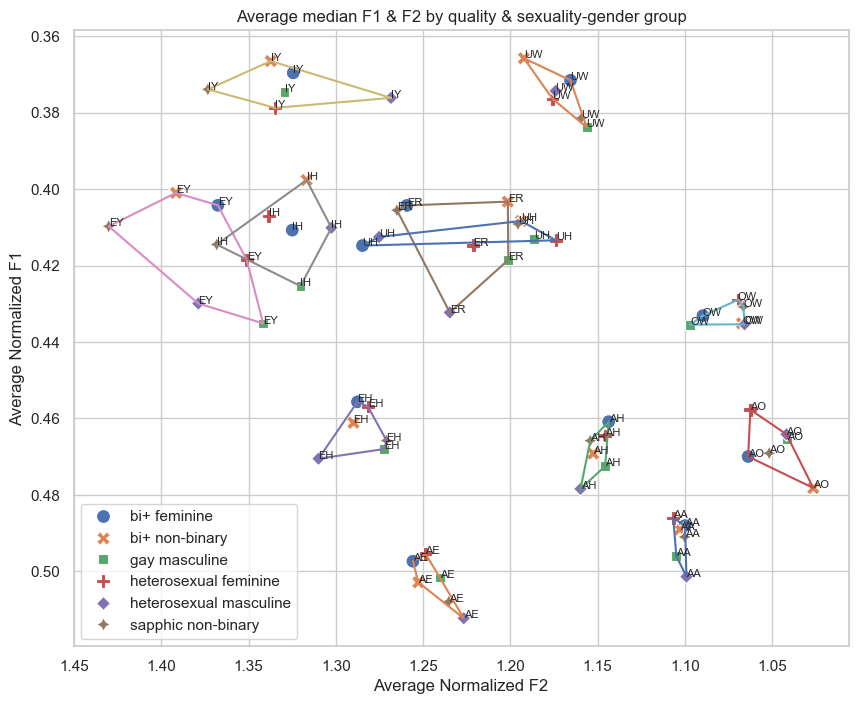

In [22]:
# Set the style
sns.set(style="whitegrid")

# Create a scatter plot
plt.figure(figsize=(10, 8))
scatter_plot = sns.scatterplot(
    x='F2_norm',
    y='F1_norm',
    hue='sexuality_gender_cut',
    data=medians_df,
    style='sexuality_gender_cut',
    s=100
)

# Add labels to each point
for _, row in medians_df.iterrows():
    plt.text(row['F2_norm'], row['F1_norm'], row['phones_short'], fontsize=8)

# Add convex hulls for each phones_short group
for phone, group in medians_df.groupby('phones_short'):
    points = group[['F2_norm', 'F1_norm']].values
    if len(points) > 2:  # ConvexHull requires at least 3 points
        hull = ConvexHull(points)
        hull_points = np.append(hull.vertices, hull.vertices[0])  # Close the hull
        plt.plot(points[hull_points, 0], points[hull_points, 1], label=f'{phone} Hull')

# Set axis labels and title
plt.xlabel('Average Normalized F2')
plt.ylabel('Average Normalized F1')
plt.title('Average median F1 & F2 by quality & sexuality-gender group')

# Optional: Invert axes
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

scatter_plot.legend_.remove()

# Add a new legend for hue only
handles, labels = scatter_plot.get_legend_handles_labels()
hue_legend_handles = handles[:len(medians_df['sexuality_gender_cut'].unique())]  # Only keep hue handles
hue_legend_labels = labels[:len(medians_df['sexuality_gender_cut'].unique())]
plt.legend(hue_legend_handles, hue_legend_labels, loc='lower left')

# Show the plot
plt.show()

## Plot by-phone, by-sexuality/gender means w/ 90th percentile density curves

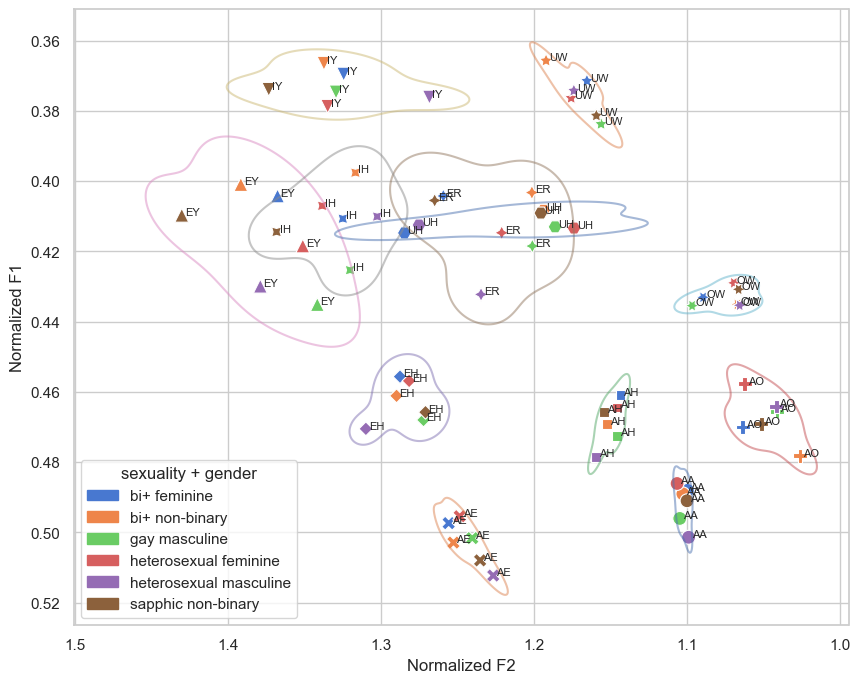

In [23]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 8))

# Scatter plot
scatter_plot = sns.scatterplot(
    x='F2_norm',
    y='F1_norm',
    hue='sexuality_gender_cut',
    data=medians_df,
    style='phones_short',
    s=100,
    palette='muted'  # Optional: Define a palette explicitly
)

# Add text labels
for _, row in medians_df.iterrows():
    plt.text(row['F2_norm'] - 0.002, row['F1_norm'], row['phones_short'], fontsize=8)

# Add KDE boundaries
for phone, group in medians_df.groupby('phones_short'):
    sns.kdeplot(
        data=group,
        x='F2_norm',
        y='F1_norm',
        levels=[0.2],
        alpha=0.5,
        label=f'{phone} Boundary'
    )

plt.xlabel('Normalized F2')
plt.ylabel('Normalized F1')
#plt.title('Average median F1 & F2 by quality & sexuality-gender group')

# Invert axes
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

# Remove the default legend
scatter_plot.legend_.remove()

# Add a new legend for hues
from matplotlib.patches import Patch

# Ensure all unique hues are included
unique_hues = medians_df['sexuality_gender_cut'].unique()
palette = sns.color_palette('muted', len(unique_hues))  # Use the same palette as scatter plot
hue_legend_handles = [
    Patch(color=palette[i], label=unique_hue) for i, unique_hue in enumerate(unique_hues)
]

plt.legend(handles=hue_legend_handles, title='sexuality + gender', loc='lower left')

plt.show()

## Highlight one vowel quality at a time

### Create subset dfs for each vowel quality

In [24]:
grouped = medians_df.groupby('phones_short')

# Loop through each group and create a new DataFrame for each 'phones_short'
for phone, subset in grouped:
    # Create a variable name for each DataFrame dynamically
    globals()[f"df_{phone}"] = subset

### Plot
Replace 'EY' with desired ARPABET symbol

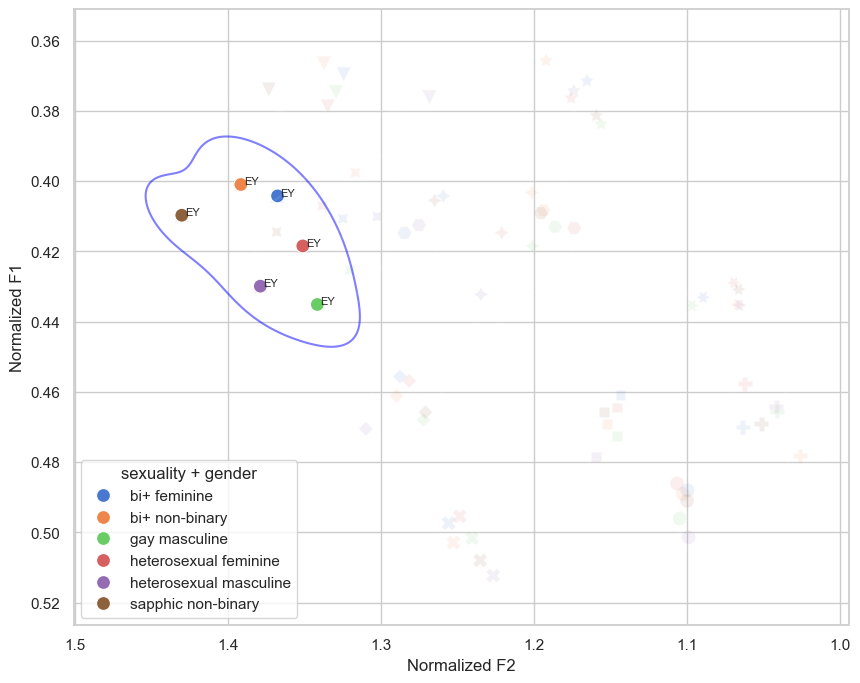

In [27]:
sns.set(style="whitegrid")

# Set up the plot
plt.figure(figsize=(10, 8))

# Scatter plot for all data with transparent points for blending
sns.scatterplot(
    x='F2_norm',
    y='F1_norm',
    hue='sexuality_gender_cut',
    data=medians_df,
    style='phones_short',
    s=100,
    palette='muted',
    alpha=0.1,
    legend=False  # Remove the default legend
)

# Add smoothed KDE boundaries
for phone, group in medians_df.groupby('phones_short'):
    if phone != 'EY':  # Background styling for other phones
        sns.kdeplot(
            data=group,
            x='F2_norm',
            y='F1_norm',
            levels=[0.2],
            alpha=0.1,
            color='white',
        )
    else:  # Highlight specific phone group
        sns.kdeplot(
            data=group,
            x='F2_norm',
            y='F1_norm',
            levels=[0.2],
            alpha=0.5,
            label='EY Boundary',
            color='blue',
        )

# Scatter plot for df_XX with distinct styling
scatter_plot = sns.scatterplot(
    x='F2_norm',
    y='F1_norm',
    hue='sexuality_gender_cut',
    data=df_EY,
    style='phones_short',
    s=100,
    palette='muted',
    alpha=1,
    legend='full'  # Ensure hue information is captured
)

# Add text labels to each point in df_XX
for _, row in df_EY.iterrows():
    plt.text(row['F2_norm'] - 0.002, row['F1_norm'], row['phones_short'], fontsize=8)

# Set axis labels and invert
plt.xlabel('Normalized F2')
plt.ylabel('Normalized F1')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

# Custom legend for hues
handles, labels = scatter_plot.get_legend_handles_labels()

# Filter handles and labels for `sexuality_gender_cut` values only
unique_hues = df_EY['sexuality_gender_cut'].unique()
hue_legend_handles = [h for h, l in zip(handles, labels) if l in unique_hues]
hue_legend_labels = [l for l in labels if l in unique_hues]

# Add a legend for hues
if hue_legend_handles and hue_legend_labels:
    plt.legend(hue_legend_handles, hue_legend_labels, title='sexuality + gender', loc='lower left')
else:
    print("No hues matched for legend.")

# Show the plot
plt.show()

## Zoom in on just one vowel quality

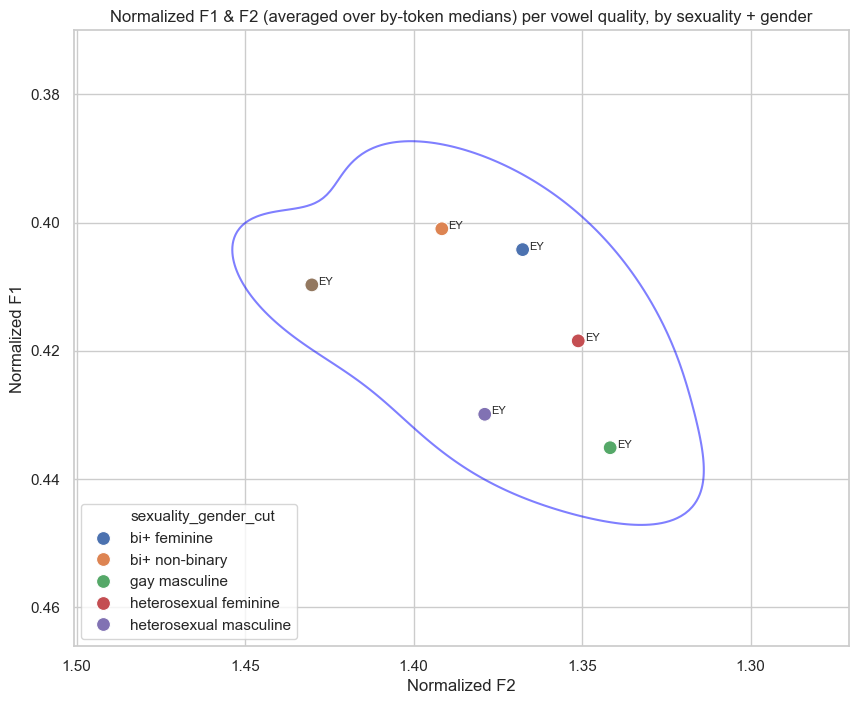

In [29]:
sns.set(style="whitegrid")

# Set up the plot
plt.figure(figsize=(10, 8))

# Scatter plot for df_XX
scatter_plot = sns.scatterplot(
    x='F2_norm',
    y='F1_norm',
    hue='sexuality_gender_cut',
    data=df_EY,  # Use df_XX instead of medians_df
    style='phones_short',
    s=100
)

# Add labels to each point in df_XX
for _, row in df_EY.iterrows():
    plt.text(row['F2_norm'] - 0.002, row['F1_norm'], row['phones_short'], fontsize=8)

# Add smoothed KDE-based boundaries for each phones_short group in df_XX
sns.kdeplot(
    data=df_EY,  # Use df_EY instead of medians_df
    x='F2_norm',
    y='F1_norm',
    levels=[0.2],  # Adjust to control boundary level
    alpha=0.5,
    label='EY Boundary',  # Label for this specific subset
    color='blue',  # Choose color as needed
)

# Set labels and title
plt.xlabel('Normalized F2')
plt.ylabel('Normalized F1')
plt.title('Normalized F1 & F2 (averaged over by-token medians) per vowel quality, by sexuality + gender')

# Invert axes
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

# Remove original legend
scatter_plot.legend_.remove()

# Add a new legend for hue only
handles, labels = scatter_plot.get_legend_handles_labels()
hue_legend_handles = handles[:len(df_EY['sexuality_gender_cut'].unique())]  # Only keep hue handles
hue_legend_labels = labels[:len(df_EY['sexuality_gender_cut'].unique())]
plt.legend(hue_legend_handles, hue_legend_labels, loc='lower left')

# Show the plot
plt.show()